# Lecture 13: Neural Networks

Imports and Helper Functions
---

In [4]:
# Original Author: Ben Marlin, Edited for extra features by Deep Chakraborty
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from sklearn.externals.six import StringIO  
from subprocess import call
from sklearn import linear_model
from sklearn import svm
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.stdout = open('/dev/stdout', 'w')

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook

In [5]:
#Define a basic MLP with pyTorch
class MLP(nn.Module):
    def __init__(self,K):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, K)
        self.out = nn.Linear(K, 1)
        self.ceriation = nn.BCELoss()
    
    def __hidden_state(self, X):
        h1 = F.sigmoid(self.fc1(X))
        return h1
    
    def _predict_proba(self, X):
        h1 = self.__hidden_state(X)
        yhat = F.sigmoid(self.out(h1))
        return yhat
        
    def forward(self, X, y):
        yhat = self._predict_proba(X)
        loss = self.ceriation(yhat,y)
        return loss  
    
    def hidden_state(self, X):
        X = Variable(torch.from_numpy(X).float())
        h1 = self.__hidden_state(X)
        return h1.data.numpy()
        
    def predict_proba(self, X):
        X = Variable(torch.from_numpy(X).float())
        yhat = self._predict_proba(X)
        return yhat.data.numpy()

    def fit(self,X,y,verbose=False):
        X2 = torch.from_numpy(X).float()
        y2 = torch.from_numpy(y[:,np.newaxis]).float()
        optimizer = optim.Adam(self.parameters(),lr=0.1,weight_decay=1e-4)

        old_loss=np.inf
        for epoch in range(100):
            optimizer.zero_grad()
            loss = self(Variable(X2), Variable(y2))
            loss.backward()
            optimizer.step()
            if(np.abs(loss.data[0]-old_loss)/np.abs(loss.data[0])<1e-6):
                break
            old_loss = loss.data[0]
            if(verbose):
                print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data[0]))
        print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data[0]))

<IPython.core.display.Javascript object>


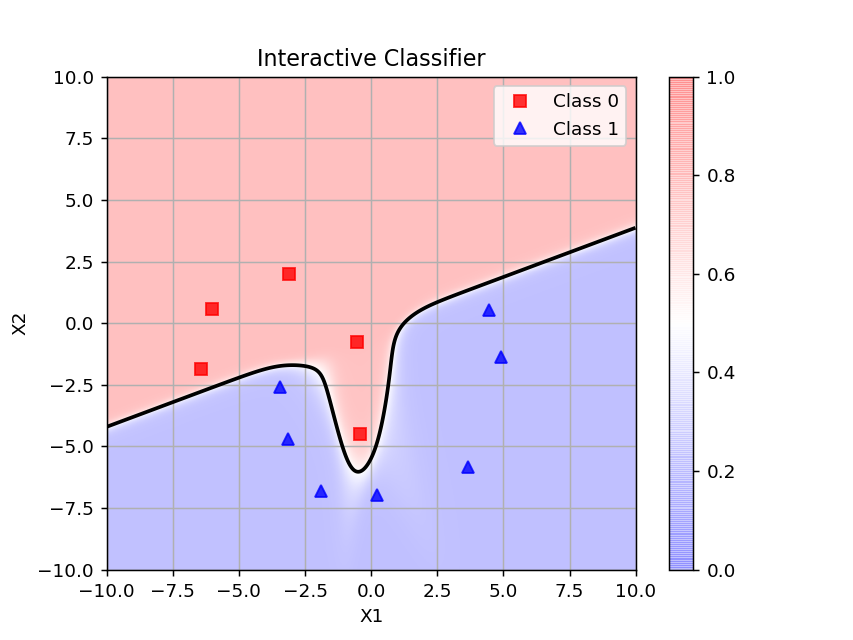

FloatSlider(value=1.0, continuous_update=False, description='Hidden Unit:', max=1.0, min=1.0, readout_format='…

<IPython.core.display.Javascript object>


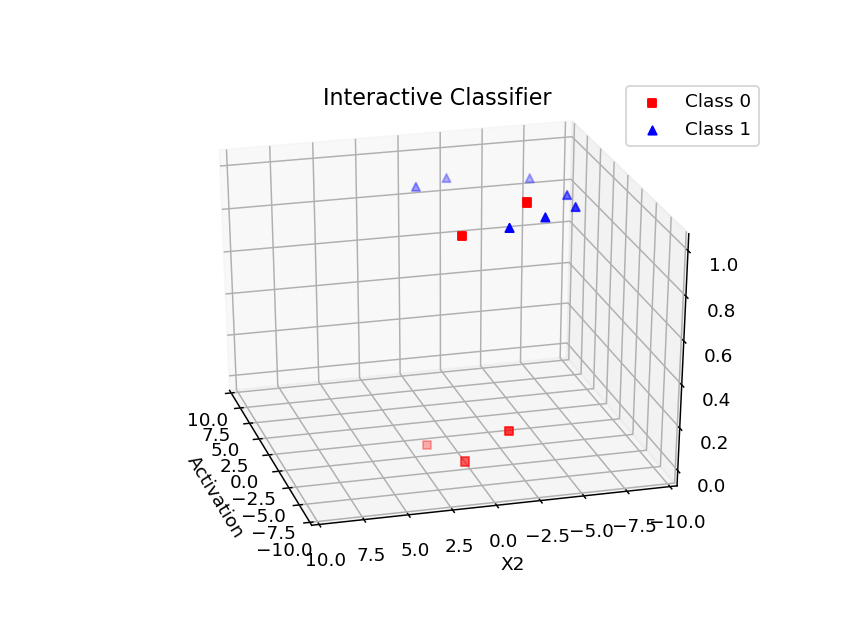

In [6]:
def clear():
    global fig1
    global ax1
    fig1.clf()
    ax1 = fig1.add_subplot(111)
    
def clear_3d():
    global fig2
    global ax2
    fig2.clf()
    ax2 = fig2.add_subplot(111, projection='3d')

def plot2d_data(x,y,data_name,class_names,feature_names,markers=['sr','^b','og']):
    """Plot a 2d data set. x must be an Nx2 array of feature values. 
    y must be a N-long array of label values. data_name is a 
    string giving the name of the data set. The class labels
    must be intergers between 1 and C. class_names must be a 
    list of strings naming the classes. feature_names must be a
    list of strings naming the features."""
    global ax1
    for i in np.arange(len(class_names)):
          ax1.plot(x[y==i,0],x[y==i,1],markers[i], alpha=0.8)
    

def plot3d_data(clf,x,y,data_name,class_names,feature_names,markers=['s','^','o'],colors=['r','b','g']):
    """Plot a 2d data set. x must be an Nx2 array of feature values. 
    y must be a N-long array of label values. data_name is a 
    string giving the name of the data set. The class labels
    must be intergers between 1 and C. class_names must be a 
    list of strings naming the classes. feature_names must be a
    list of strings naming the features."""
    global ax2
    global h
    z = clf.hidden_state(x)
    for i in np.arange(len(class_names)):
          ax2.scatter(x[y==i,0], x[y==i,1], z[y==i][:,h-1], c=colors[i], marker=markers[i])
    ax2.legend(class_names)
    ax2.set_xlim((-10,10))
    ax2.set_ylim((-10,10))
    ax2.set_title(data_name) 
    ax2.grid(True)
    ax2.set_xlabel(feature_names[0]);
    ax2.set_ylabel(feature_names[1]);
    ax2.set_xlabel('Activation')
#     plt.draw()
            
def interactive_classifier():
    """Define an interactive classifier. clf can be any classifier
    object that implements predict. fig must be a figure handle
    to a 2d data plot created using plot2d_data(). The function
    applies the classifier to the points that you click on and
    plots them in the specified figure.
    """
    global fig1
    global clf
    
    #Define the event handler
    def onclick(event):
        global N
        global x_tr
        global y_tr
        global dclass
        global clf
        markers=['sr','^b','og']
        #Get the point that is clicked on
        x = np.array([event.xdata, event.ydata])
        
        x_tr[N,:]=x
        y_tr[N]=dclass
        N=N+1
        clear()
        clear_3d()
        plot_prob_classifier(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])
    
    #Create a callback to connect the handler to mouse click events 
    cid = fig1.canvas.mpl_connect('button_press_event', onclick)


#Define classifier plotting function
def plot_prob_classifier(clf,x,y,data_name,class_names,feature_names,show_data=True,markers=['sr','^b','og'], ax=None):  
    global ax1
    global ax2
    global fig1
    
    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(-10, 10,1/100.0 ),np.arange(-10, 10,1/100.0))

    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx   = np.vstack((gx1l,gx2l)).T    
    
    if(N>0):
        plot2d_data(x,y,data_name,class_names,feature_names)
    
    if( N>1 and np.any(y==1) and np.any(y==0)):
        #Compute a prediction for every point in the grid
        #global K
        clf.fit(x,y)
        gyhat = 1-clf.predict_proba(gx)[:,0]
        gyhat = gyhat.reshape(gx1.shape)
        contours = ax1.contour(gx1, gx2, gyhat, levels=[0.5], linewidths=2,
                           linetypes='-',colors=["k"])  
        im = ax1.imshow(gyhat, interpolation='nearest',
               extent=(-10, 10, -10, 10), aspect='auto',
               origin='lower', cmap=plt.cm.bwr, alpha=0.25, vmin=0, vmax=1)
        plot3d_data(clf,x,y,data_name,class_names,feature_names)
 
    else:
        gx1[:]=0.5
        im = ax1.imshow(gx1, interpolation='nearest',
               extent=(-10, 10, -10, 10), aspect='auto',
               origin='lower', cmap=plt.cm.bwr, alpha=0.25, vmin=0, vmax=1)
    
    fig1.colorbar(im, ax=ax1)
    ax1.legend(class_names)
    ax1.set_xlim((-10,10))
    ax1.set_ylim((-10,10))
    ax1.set_title(data_name) 
    ax1.grid(True)
    ax1.set_xlabel(feature_names[0]);
    ax1.set_ylabel(feature_names[1]);
    
#     plt.draw()
#     plt.show()
    
dclass=0
wclass = widgets.RadioButtons(
    options=['0', '1'],
    description='Class:',
    disabled=False
)

wK = widgets.FloatSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='K:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

wH = widgets.FloatSlider(
    value=1,
    min=1,
    max=1,
    step=1,
    description='Hidden Unit:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

wbutton = widgets.Button(description="Reset")
wlearn = widgets.Button(description="Learn")
wrand = widgets.Button(description="Randomize")

items1 = [wclass, wK]
items2 = [wlearn, wrand, wbutton]
whbox1 = widgets.HBox(items1)  
whbox2 = widgets.HBox(items2)
wvbox  = widgets.VBox([whbox1,whbox2])

def on_wclass_change(change):
    global dclass
    print(change)
    dclass = int(change.new)
    print(dclass)
    
wclass.observe(on_wclass_change, names='value')


def on_wbutton_clicked(b):
    init_classifier()
    
wbutton.on_click(on_wbutton_clicked)

def on_wlearn_clicked(b):
    global x_tr
    global y_tr
    global clf
    global N
    clf.fit(x_tr[:N,:],y_tr[:N])
    clear()
    clear_3d()
    plot_prob_classifier(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])
   
wlearn.on_click(on_wlearn_clicked)

def on_wrand_clicked(b):
    global x_tr
    global y_tr
    global clf
    global N
    global K
    clf = MLP(K)
    clear()
    clear_3d()
    plot_prob_classifier(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])
   
wrand.on_click(on_wrand_clicked)

def on_K_change(change):
    global clf
    global x_tr
    global y_tr
    global clf
    global N
    global K
    global wH
    global h
    
    K = int(change.new)
    h = 1
    wH.max = K
    wH.value = 1
    clf = MLP(K)
    clear()
    clear_3d()
    plot_prob_classifier(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])

wK.observe(on_K_change, names='value')

def on_H_change(change):
    global clf
    global x_tr
    global y_tr
    global N
    global K
    global wH
    global ax2
    global h
    
    h = int(change.new)
    clear_3d()
    if( N>1 and np.any(y_tr==1) and np.any(y_tr==0)):
        plot3d_data(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])

wH.observe(on_H_change, names='value')

def init_classifier():
    global N
    global x_tr
    global y_tr
    global clf
    global K
    global h
    N=0
    K=1
    h=1
    x_tr = np.zeros((100,2))
    y_tr = np.zeros(100)
    wH.value=1
    wK.value=1
    clf  = MLP(K)
    clear()
    clear_3d()
    plot_prob_classifier(clf,x_tr[:N,:],y_tr[:N],"Interactive Classifier",["Class 0","Class 1"],["X1","X2"])
    
display(wvbox)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
display(wH)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
init_classifier()
interactive_classifier()

